In [2]:
import talib
from data_sources import get_prices_in_range, get_volumes_in_range
from strategies import  Horizon
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from signals import Signal
from strategies import SignalSignatureStrategy, SimpleRSIStrategy
import operator
from orders import OrderType

# Initial settings
transaction_currency = "ETH"
counter_currency = "BTC"
end_time = 1526637600
start_time = end_time - 60 * 60 * 24 * 60
horizon = Horizon.short
resample_period = 60
start_cash = 1
start_crypto = 0
source = 0
strength = 3
history_size = 100
AVERAGING_PERIOD = 50*60

# Load price and volume data and calculate average prices and volumes
prices_df = get_prices_in_range(start_time, end_time, transaction_currency, counter_currency, source)
prices_df.price /= 1E8

volumes_df = get_volumes_in_range(start_time, end_time, transaction_currency, counter_currency, source)
volumes_df.volume /= 1E5 # scaling for visualization

sma_price = talib.SMA(np.array(prices_df.price, dtype=float), timeperiod=AVERAGING_PERIOD)
sma_volume = talib.SMA(np.array(volumes_df.volume, dtype=float), timeperiod=AVERAGING_PERIOD)

prices_df['average_price'] = pd.Series(sma_price, index=prices_df.index)
volumes_df['average_volume'] = pd.Series(sma_volume, index=volumes_df.index)
price_volume_df = prices_df.join(volumes_df)

# Convert indexes to datetime
prices_df.index = pd.to_datetime(prices_df.index, unit='s')
volumes_df.index = pd.to_datetime(volumes_df.index, unit='s')
price_volume_df.index = pd.to_datetime(price_volume_df.index, unit='s')


In [3]:
def build_signals(percent_change_price, percent_change_volume):
    # build signals
    all_buy_signals = []
    first_cross_buy_signals = []
    valid_in_previous_step = False
    for row in price_volume_df.itertuples():
        timestamp = row.Index.timestamp()
        price = row.price
        volume = row.volume
        avg_price = row.average_price
        avg_volume = row.average_volume

        # check whether to generate a buy signal:
        if price > (1 + percent_change_price)*avg_price and volume > (1 + percent_change_volume)*avg_volume:
            signal = Signal("RSI", 1, Horizon.any, 3, 3, price, 0, timestamp, 0, transaction_currency, counter_currency)
            all_buy_signals.append(signal)
            if not valid_in_previous_step:
                valid_in_previous_step = True
                first_cross_buy_signals.append(signal)
                # print(timestamp, price, avg_price, volume, avg_volume)
        else:
            valid_in_previous_step = False
    return all_buy_signals, first_cross_buy_signals


In [4]:
def build_strategy(percent_change_price, percent_change_volume, buy_only_on_first_cross=True, sell_strategy = None):
    all_buy_signals, first_cross_buy_signals = build_signals(percent_change_price, percent_change_volume)
    
    if sell_strategy is None:
        strategy = SignalSignatureStrategy(["rsi_buy_2", "rsi_sell_2", "rsi_buy_3", "rsi_sell_3"],
                                           start_time, end_time, horizon,
                                           counter_currency, transaction_currency, source)
    else:
        strategy = sell_strategy
        
    rsi_sell_signals = strategy.get_sell_signals()
    
    if buy_only_on_first_cross:
        buy_signals = first_cross_buy_signals
    else:
        buy_signals = all_buy_signals

    buy_signals.extend(rsi_sell_signals)
    sorted_signals = sorted(buy_signals, key=operator.attrgetter('timestamp'))
    
    # burn in hell hacky, but it works :)
    strategy.signals = sorted_signals
    return strategy, all_buy_signals, first_cross_buy_signals


In [5]:
strategy, all_buy_signals, first_cross_buy_signals = build_strategy(0,0,buy_only_on_first_cross=True)
orders, _ = strategy.get_orders(start_cash, start_crypto)

# Backtest the strategy
print(strategy.evaluate(start_cash, start_crypto, start_time, end_time))


Strategy: a simple signal set-based strategy
  description: trading according to signal set ['rsi_buy_2', 'rsi_sell_2', 'rsi_buy_3', 'rsi_sell_3']
Strategy settings:
  horizon = short
--

* Order execution log *

Start balance: cash = 1 BTC, crypto = 0 
Start time: 2018-03-19 10:00:00
--
--
2018-03-25 18:37:19  	 OrderType.BUY    	 cash_balance ->         -1.00 BTC 	 currency_balance ->     16.307128 ETH 	 (1 ETH = 0.06116957 BTC )
   signal: rsi_buy_3 strength=3 trend=1 horizon=Horizon.any timestamp=2018-03-25 18:37:19 rsi_value=0
2018-04-09 10:00:00  	 OrderType.SELL   	 cash_balance ->          0.97 BTC 	 currency_balance ->    -16.307128 ETH 	 (1 ETH = 0.05957500 BTC )
   signal: rsi_sell_2 strength=2 trend=-1 horizon=0 timestamp=2018-04-09 10:00:00 rsi_value=79.8665786455173
2018-04-11 19:23:52  	 OrderType.BUY    	 cash_balance ->         -0.97 BTC 	 currency_balance ->     15.872646 ETH 	 (1 ETH = 0.06090010 BTC )
   signal: rsi_buy_3 strength=3 trend=1 horizon=Horizon.any times

In [39]:
def plot_results(include_all_buy=True, include_first_cross=False, include_orders=True):
    
    ax = price_volume_df.plot(lw=1, title="ETH to BTC")
    volumes_df.plot(lw=2)

    if include_all_buy:
        for signal in all_buy_signals:
            timestamp = pd.to_datetime(signal.timestamp, unit="s")
            price = signal.price
            if signal.trend == 1:
                #ax.axvline(timestamp, color="lightgreen", lw=1)
                circle = plt.Circle((timestamp, price), 0.1, color="lightgreen")
                ax.add_artist(circle)

    if include_first_cross:
        for signal in first_cross_buy_signals:
            timestamp = pd.to_datetime(signal.timestamp, unit="s")
            price = signal.price
            ax.axvline(timestamp, color="pink", lw=1)
            #circle = plt.Circle((timestamp, price), 0.05, color="lightgreen")
            #ax.add_artist(circle)

    if include_orders:
        for order in orders:
            if order.order_type == OrderType.BUY:
                color = "g"
            else:
                color = "r"
            timestamp = pd.to_datetime(order.timestamp, unit="s")
            #timestamp = order.timestamp
            #price = order.unit_price
            ax.axvline(timestamp, color=color, lw=2)
            #circle = plt.Circle((timestamp, price), 0.05, color=color)
            #ax.add_artist(circle)

    ax.set_yticklabels([])
    plt.show()


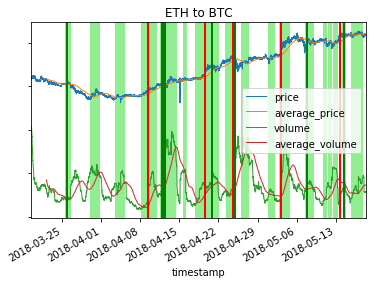

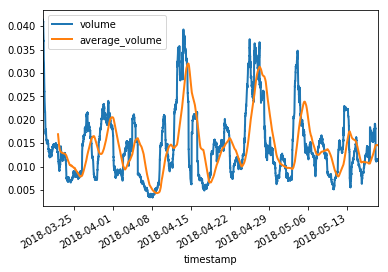

In [7]:
plot_results(include_all_buy=True, include_first_cross=False, include_orders=True)


Strategy: a simple signal set-based strategy
  description: trading according to signal set ['rsi_buy_2', 'rsi_sell_2', 'rsi_buy_3', 'rsi_sell_3']
Strategy settings:
  horizon = short
--

* Order execution log *

Start balance: cash = 1 BTC, crypto = 0 
Start time: 2018-03-19 10:00:00
--
--
2018-03-30 06:21:31  	 OrderType.BUY    	 cash_balance ->         -1.00 BTC 	 currency_balance ->     17.539766 ETH 	 (1 ETH = 0.05687077 BTC )
   signal: rsi_buy_3 strength=3 trend=1 horizon=Horizon.any timestamp=2018-03-30 06:21:31 rsi_value=0
2018-04-09 10:00:00  	 OrderType.SELL   	 cash_balance ->          1.04 BTC 	 currency_balance ->    -17.539766 ETH 	 (1 ETH = 0.05957500 BTC )
   signal: rsi_sell_2 strength=2 trend=-1 horizon=0 timestamp=2018-04-09 10:00:00 rsi_value=79.8665786455173
2018-04-09 18:59:05  	 OrderType.BUY    	 cash_balance ->         -1.04 BTC 	 currency_balance ->     17.739592 ETH 	 (1 ETH = 0.05860977 BTC )
   signal: rsi_buy_3 strength=3 trend=1 horizon=Horizon.any times

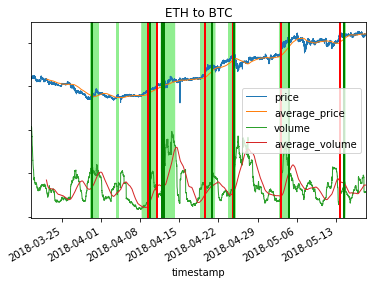

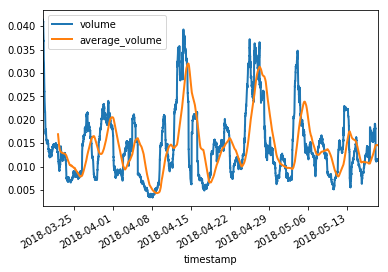

In [8]:
# Let's try another threshold
strategy, all_buy_signals, first_cross_buy_signals = build_strategy(0.02,0.02)
orders, _ = strategy.get_orders(start_cash, start_crypto)

# Backtest the strategy
print(strategy.evaluate(start_cash, start_crypto, start_time, end_time))

# Plot trades
plot_results(True, False, True)

In [9]:
# Try out different thresholds for volume and price change
def calculate_profits(sell_strategy = None):
    volume_change_percents = []
    price_change_percents = []
    profits = []
    
    for percent_change_volume in np.arange(0, 0.10, 0.005):
        for percent_change_price in np.arange(0, 0.10, 0.005):
            strategy, all_buy_signals, first_cross_buy_signals = build_strategy(percent_change_volume,
                                                                                percent_change_price,
                                                                                buy_only_on_first_cross=True,
                                                                                sell_strategy=sell_strategy)
            orders, _ = strategy.get_orders(start_cash, start_crypto)
            evaluation = strategy.evaluate(start_cash, start_crypto, start_time, end_time, verbose=False)
            volume_change_percents.append(percent_change_volume)
            price_change_percents.append(percent_change_price)
            profits.append(evaluation.get_profit_percent())
    profit_df = pd.DataFrame.from_items(zip(["Volume change percent", "Price change percent", "Profit percent"], [volume_change_percents, price_change_percents, profits]))
    return profit_df

        

In [10]:
overbought_threshold = 95
oversold_threshold = 25
sell_strategy = SimpleRSIStrategy(start_time, end_time, horizon, counter_currency, 
                                  overbought_threshold, oversold_threshold, 
                                  transaction_currency, "RSI", source)
profit_df = calculate_profits(sell_strategy)

In [11]:
def plot_profit_df(profit_df, title=""):
    
    # Plot scatter
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    x = profit_df["Volume change percent"]
    y = profit_df["Price change percent"]
    z = profit_df["Profit percent"]
    
    
    ax.scatter(x, y, z, c='r', marker='o')
    
    ax.set_xlabel('Volume change threshold')
    ax.set_ylabel('Price change threshold')
    ax.set_zlabel('Profit [%]')
    
    plt.title(title)
    plt.show()
    
    # Plot surface
    # Interpolated mesh
    
    #%matplotlib notebook
    #plt.interactive(True)
    
    fig3d = plt.figure(1)
    
    ax = fig3d.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(x, y)
    from scipy.interpolate import griddata
    from matplotlib import cm
    Z = griddata((x, y), z, (X, Y), method='cubic')
    
    surface_plot = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_xlabel('Volume change threshold')
    ax.set_ylabel('Price change threshold')
    ax.set_zlabel('Profit [%]')
    
    plt.show()

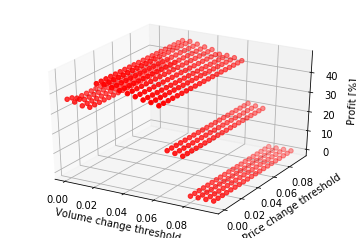

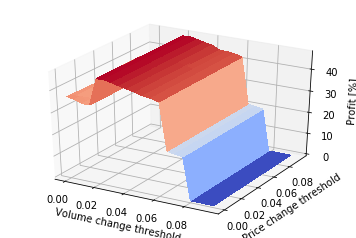

In [13]:
plot_profit_df(profit_df)

In [33]:
def write_to_excel(df, path):
    writer = pd.ExcelWriter(path)
    df.to_excel(writer,"Results")
    writer.save()

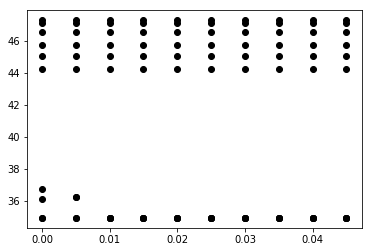

In [60]:
plt.plot(profit_df["Price change percent"], profit_df["Profit percent"], 'o', color='black');

In [59]:
# Find best performing parameters
sorted_by_profit = profit_df.sort_values("Profit percent", inplace=False, ascending=False)
sorted_by_profit

,Volume change percent,Price change percent,Profit percent
50,0.025,0.000,47.288007
59,0.025,0.045,47.288007
57,0.025,0.035,47.288007
56,0.025,0.030,47.288007
55,0.025,0.025,47.288007
54,0.025,0.020,47.288007
53,0.025,0.015,47.288007
52,0.025,0.010,47.288007
51,0.025,0.005,47.288007
58,0.025,0.040,47.288007


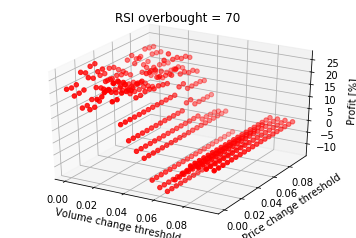

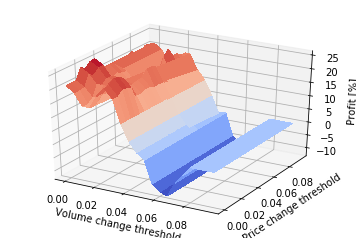

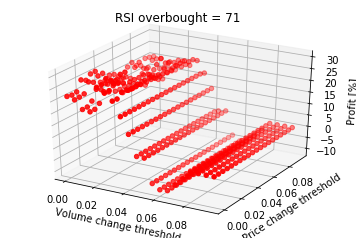

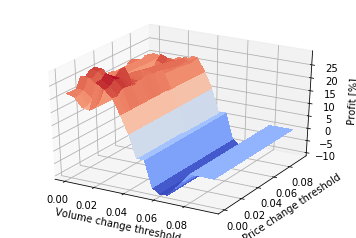

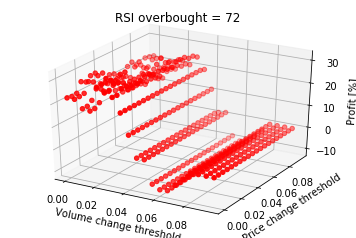

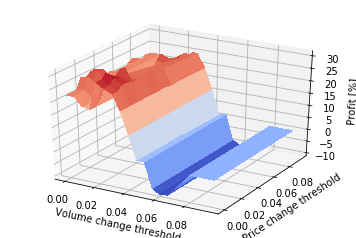

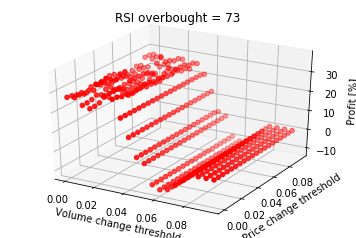

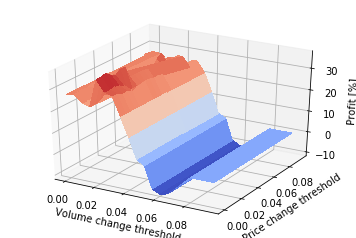

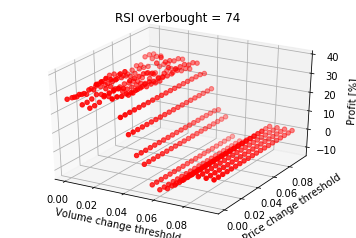

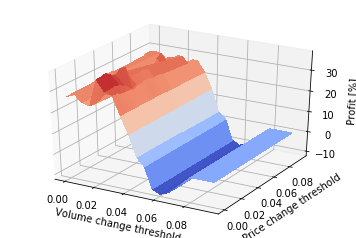

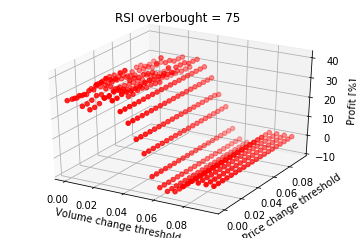

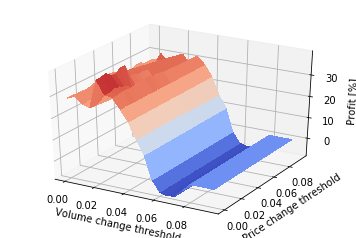

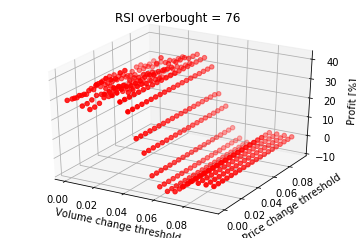

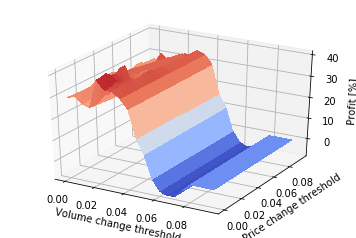

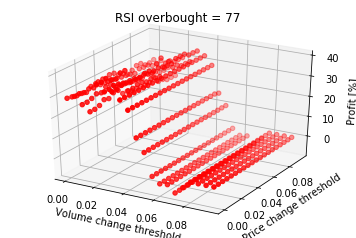

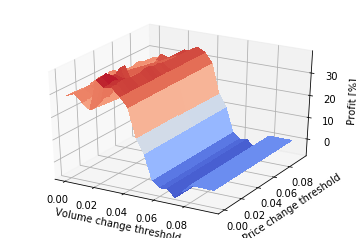

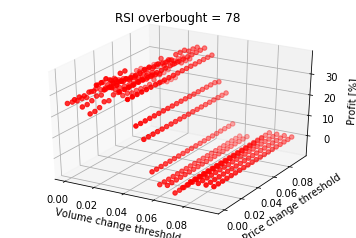

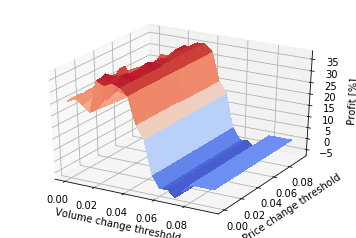

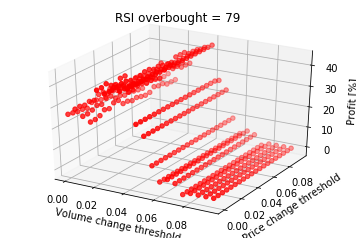

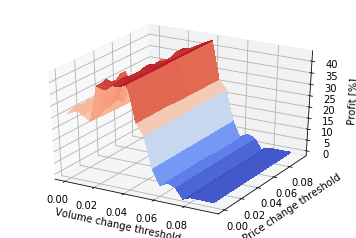

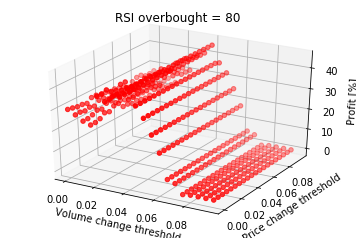

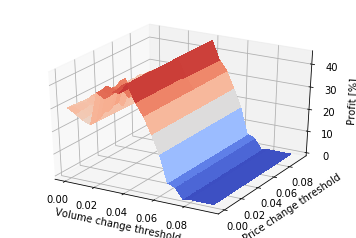

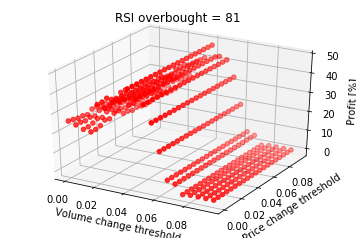

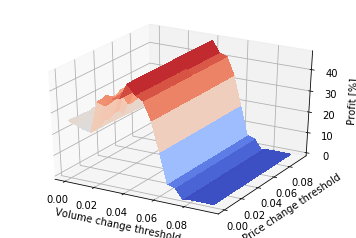

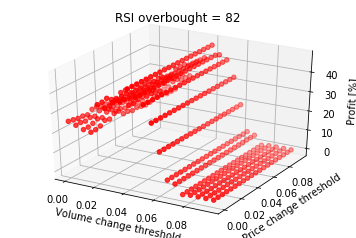

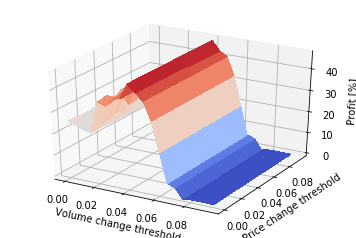

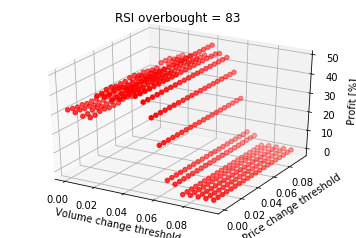

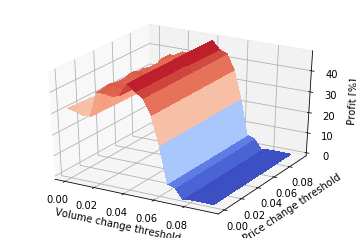

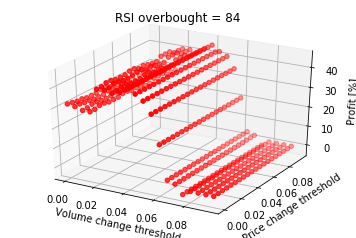

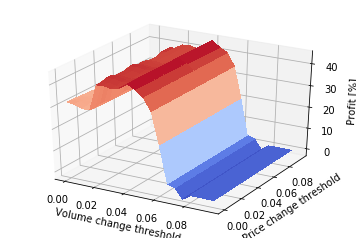

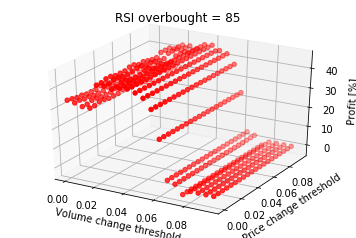

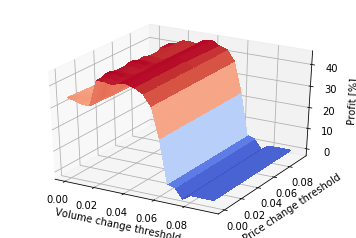

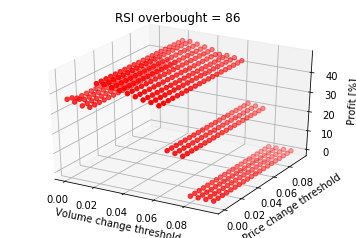

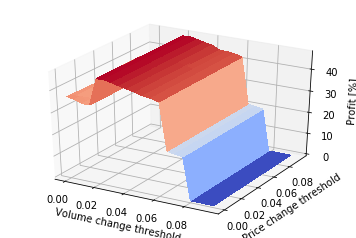

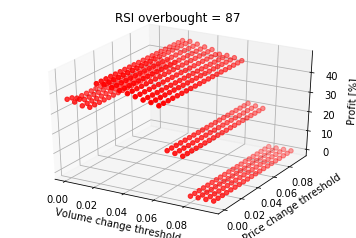

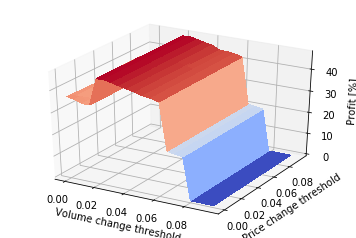

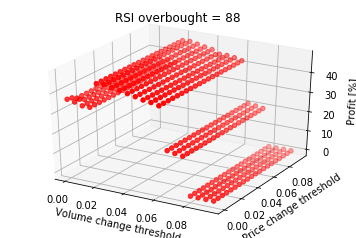

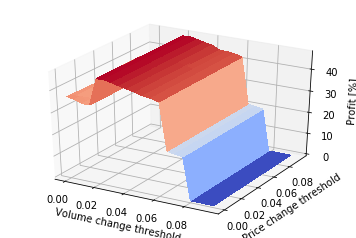

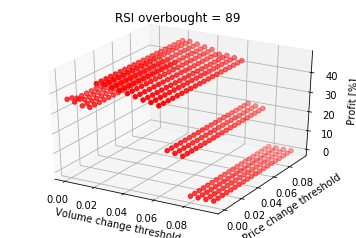

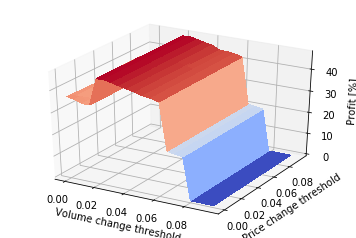

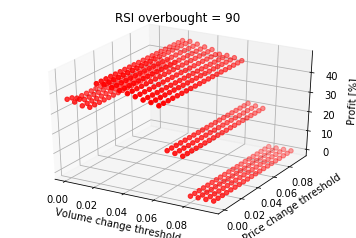

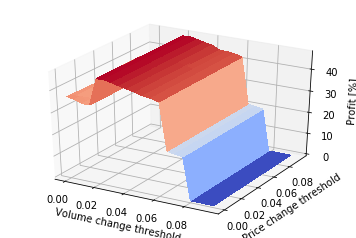

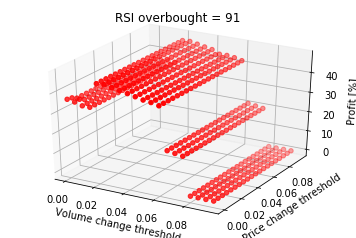

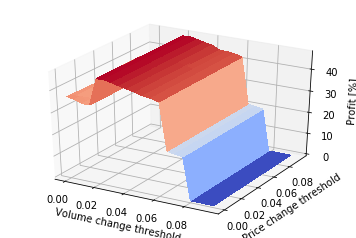

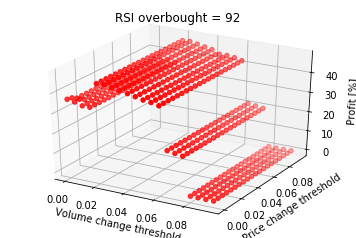

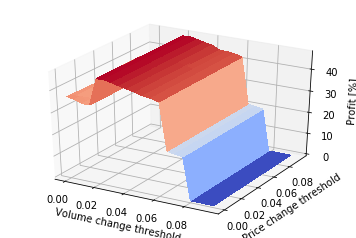

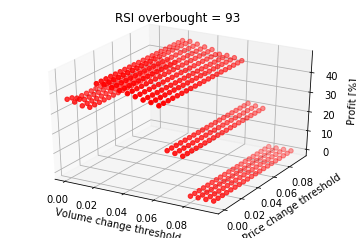

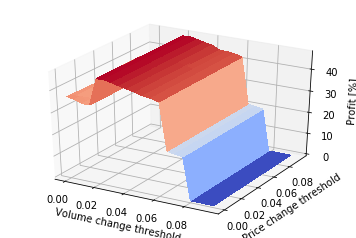

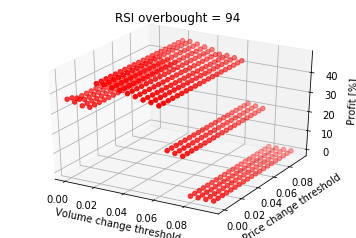

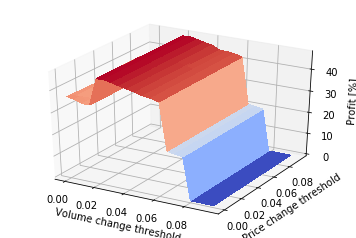

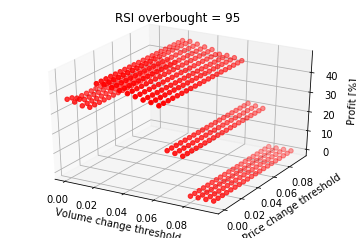

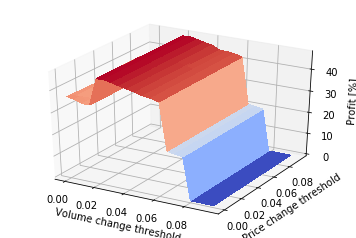

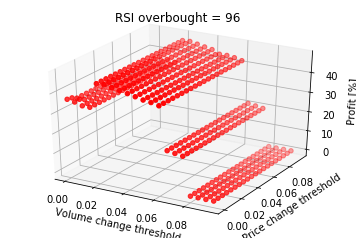

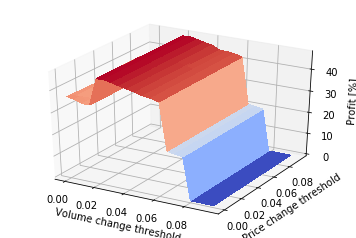

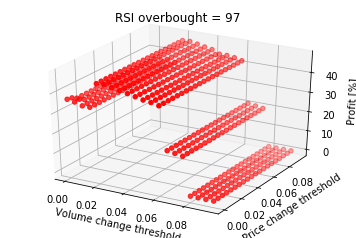

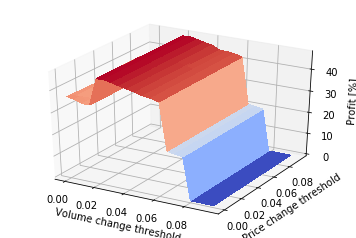

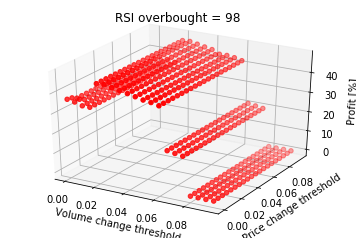

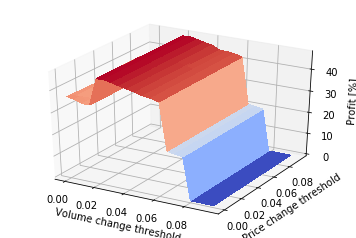

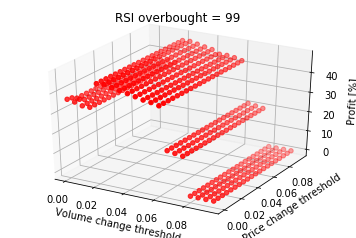

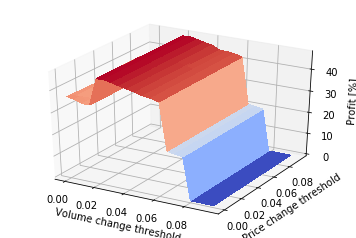

In [29]:
# Explore how RSI overbought influences the results
all_results = None
oversold_threshold = 20 # not used
for overbought_threshold in range(70,100):
    sell_strategy = SimpleRSIStrategy(start_time, end_time, horizon, counter_currency, 
                                      overbought_threshold, oversold_threshold, 
                                      transaction_currency, "RSI", source)
    profit_df = calculate_profits(sell_strategy)
    profit_df
    profit_df['RSI overbought'] = pd.Series([overbought_threshold] * len(profit_df), index=profit_df.index)
    if all_results is None:
        all_results = profit_df
    else:
        all_results = all_results.append(profit_df, ignore_index=True)
    plot_profit_df(profit_df, "RSI overbought = {}".format(overbought_threshold))

In [31]:
all_results


,Volume change percent,Price change percent,Profit percent,RSI overbought
0,0.000,0.000,21.190680,70
1,0.000,0.005,20.741199,70
2,0.000,0.010,21.072266,70
3,0.000,0.015,25.046161,70
4,0.000,0.020,23.899325,70
5,0.000,0.025,25.579379,70
6,0.000,0.030,25.708598,70
7,0.000,0.035,20.163749,70
8,0.000,0.040,19.927721,70
9,0.000,0.045,21.193655,70


In [32]:
sorted_by_profit = all_results.sort_values("Profit percent", inplace=False, ascending=False)
sorted_by_profit

,Volume change percent,Price change percent,Profit percent,RSI overbought
5371,0.040,0.055,48.268714,83
5369,0.040,0.045,48.268714,83
5379,0.040,0.095,48.268714,83
5377,0.040,0.085,48.268714,83
5376,0.040,0.080,48.268714,83
5375,0.040,0.075,48.268714,83
5374,0.040,0.070,48.268714,83
5373,0.040,0.065,48.268714,83
5372,0.040,0.060,48.268714,83
5370,0.040,0.050,48.268714,83


In [34]:
write_to_excel(all_results, "vbi_backtesting.xlsx")

Strategy: a simple RSI-based strategy
  description: selling when rsi_value >= overbought_threshold, buying when rsi_value <= oversold threshold 
Strategy settings:
  overbought_threshold = 83.0
  oversold_threshold = 20
  horizon = short
--

* Order execution log *

Start balance: cash = 1 BTC, crypto = 0 
Start time: 2018-03-19 10:00:00
--
--
2018-03-30 22:12:31  	 OrderType.BUY    	 cash_balance ->         -1.00 BTC 	 currency_balance ->     17.295165 ETH 	 (1 ETH = 0.05767508 BTC )
   signal: rsi_buy_3 strength=3 trend=1 horizon=Horizon.any timestamp=2018-03-30 22:12:31 rsi_value=0
2018-04-19 19:00:00  	 OrderType.SELL   	 cash_balance ->          1.16 BTC 	 currency_balance ->    -17.295165 ETH 	 (1 ETH = 0.06750000 BTC )
   signal: rsi_sell_3 strength=3 trend=-1 horizon=0 timestamp=2018-04-19 19:00:00 rsi_value=84.1217768032561
2018-04-19 19:14:51  	 OrderType.BUY    	 cash_balance ->         -1.16 BTC 	 currency_balance ->     17.249798 ETH 	 (1 ETH = 0.06733956 BTC )
   signal:

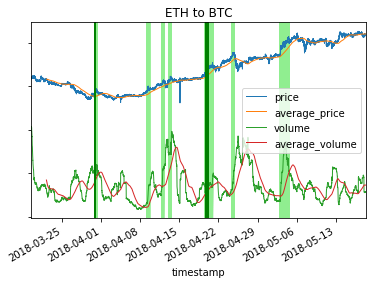

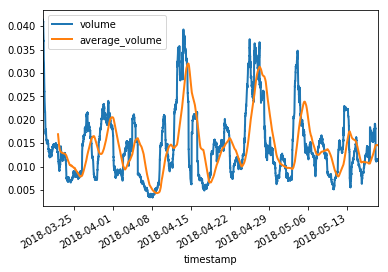

In [40]:
# Analyze the best parameter combination
overbought_threshold = sorted_by_profit.iloc[0]["RSI overbought"]
percent_change_volume = sorted_by_profit.iloc[0]["Volume change percent"]
percent_change_price = sorted_by_profit.iloc[0]["Price change percent"]

sell_strategy = SimpleRSIStrategy(start_time, end_time, horizon, counter_currency, 
                                      overbought_threshold, oversold_threshold, 
                                      transaction_currency, "RSI", source)
strategy, all_buy_signals, first_cross_buy_signals = build_strategy(percent_change_volume,
                                                                                percent_change_price,
                                                                                buy_only_on_first_cross=True,
                                                                                sell_strategy=sell_strategy)
orders, _ = strategy.get_orders(start_cash, start_crypto)
evaluation = strategy.evaluate(start_cash, start_crypto, start_time, end_time, verbose=True)

plot_results()

In [41]:
# Let's establish the buy and hold baseline
from strategies import BuyAndHoldTimebasedStrategy
bah = BuyAndHoldTimebasedStrategy(start_time, end_time, transaction_currency, counter_currency, source)
bah.evaluate(start_cash, start_crypto, start_time, end_time)

--

* Order execution log *

Start balance: cash = 1 BTC, crypto = 0 
Start time: 2018-03-19 10:00:00
--
--
2018-03-19 10:00:00  	 OrderType.BUY    	 cash_balance ->         -1.00 BTC 	 currency_balance ->     15.473554 ETH 	 (1 ETH = 0.06446483 BTC )
2018-05-18 10:00:00  	 OrderType.SELL   	 cash_balance ->          1.29 BTC 	 currency_balance ->    -15.473554 ETH 	 (1 ETH = 0.08387499 BTC )
End time: 2018-05-18 10:00:00

Summary
--
Number of trades: 2
End cash: 1.29 BTC
End crypto: 0.000000 ETH
Total value invested: 1 BTC
Total value after investment: 1.29 BTC (+29.46%)
Profit: 0.29 BTC
Total value invested: 8196.25 USDT (conversion on 2018-03-19 10:00:00)
Total value after investment: 10484.95 USDT (+27.92%) (conversion on 2018-05-18 10:00:00)
Profit: 2288.70 USDT


Strategy: a simple RSI-based strategy
  description: selling when rsi_value >= overbought_threshold, buying when rsi_value <= oversold threshold 
Strategy settings:
  overbought_threshold = 83.0
  oversold_threshold = 20
  horizon = short
--

* Order execution log *

Start balance: cash = 1 BTC, crypto = 0 
Start time: 2018-03-19 10:00:00
--
--
2018-03-30 06:21:31  	 OrderType.BUY    	 cash_balance ->         -1.00 BTC 	 currency_balance ->     17.539766 ETH 	 (1 ETH = 0.05687077 BTC )
   signal: rsi_buy_3 strength=3 trend=1 horizon=Horizon.any timestamp=2018-03-30 06:21:31 rsi_value=0
2018-04-19 19:00:00  	 OrderType.SELL   	 cash_balance ->          1.18 BTC 	 currency_balance ->    -17.539766 ETH 	 (1 ETH = 0.06750000 BTC )
   signal: rsi_sell_3 strength=3 trend=-1 horizon=0 timestamp=2018-04-19 19:00:00 rsi_value=84.1217768032561
2018-04-20 19:57:46  	 OrderType.BUY    	 cash_balance ->         -1.18 BTC 	 currency_balance ->     16.852898 ETH 	 (1 ETH = 0.06990026 BTC )
   signal:

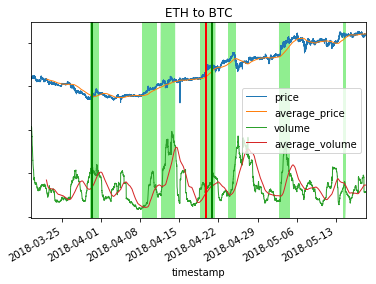

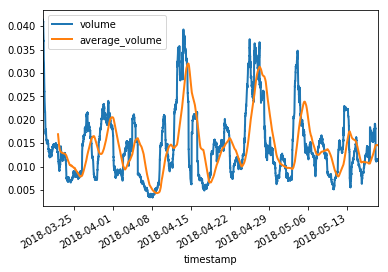

In [42]:
# Analyze the best parameter combination
overbought_threshold = sorted_by_profit.iloc[0]["RSI overbought"]
percent_change_volume = sorted_by_profit.iloc[0]["Volume change percent"]/2
percent_change_price = sorted_by_profit.iloc[0]["Price change percent"]

sell_strategy = SimpleRSIStrategy(start_time, end_time, horizon, counter_currency, 
                                      overbought_threshold, oversold_threshold, 
                                      transaction_currency, "RSI", source)
strategy, all_buy_signals, first_cross_buy_signals = build_strategy(percent_change_volume,
                                                                                percent_change_price,
                                                                                buy_only_on_first_cross=True,
                                                                                sell_strategy=sell_strategy)
orders, _ = strategy.get_orders(start_cash, start_crypto)
evaluation = strategy.evaluate(start_cash, start_crypto, start_time, end_time, verbose=True)

plot_results()